# CSE 590 Project

In [1]:
# The following is for creating embedding datasets for training pytorch NN's for multi-classification
from sentence_transformers import SentenceTransformer      # We use this to create datasets with the text already embedded as dense vectors
import torch                                               # For training neural networks on the data...
import numpy as np

# The following is for fine-tuning GPT-2 for classification task
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import Trainer, TrainingArguments
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

# Other helper modules
import random
from tqdm import tqdm # use this for getting embeddings with batching and the loaders later
import pandas as pd

## Define classes and functions here!

In [10]:
# These can eventually go into the utils.py!
##############################################################################
#         General Purpose Functions 
##############################################################################
def set_seed(seed): # referencing supplemental materials from Andriy Burkov's "The Hundred-page Language Models Book"
    """
    Set all seeds to have reproducibility!

    Args:
        seed := Integer seed value for random number generation
    """
    
    random.seed(seed)                   # Python's built-in random seed
    torch.manual_seed(seed)             # CPU random seed
    torch.cuda.manual_seed_all(seed)    # GPU random seed

    
    # Request cuDNN to use deterministic algorithms
    torch.backends.cudnn.deterministic = True
    # Disable cuDNN's auto-tuner for consistent behavior
    torch.backends.cudnn.benchmark = False


def set_hyperparameters(): # referencing Andriy Burkov's "The Hundred-page Language Models Book"
    """
    Simple function to return the typical hyperparameters such as number of epochs, batch size and learning rate
    """
    num_epochs=1 # previous fine-tuned model used 3 epochs
    batch_size=32
    learning_rate=2e-5
    return num_epochs, batch_size, learning_rate
     

def get_df(which_df):
    '''
        A function to get one of our preprocessed datasets. Everything should expect a pandas DataFrame named 'df_complete'

    '''
    if which_df == 'pulk17':
    #######################################
    #           PRE-PROCESS DATA (BINARY CLASSIFICATION)
    #######################################

        df = pd.read_csv("hf://datasets/Pulk17/Fake-News-Detection-dataset/train.tsv", sep="\t")
        #df['text'] = 'A news story dated to ' + df['date'] + ' has the title ' + '"' + df["title"] + '"' + ' The subject is ' + df['subject'] +' and says the following: ' + df["text"].astype(str)
        print(df.head(5))
        print(df['text'][0])

        df['split'] = None # initialize this now, set it after we get our splits' indices

        # Create train / test / valid split, then create our set of embedding datasets, and likewise prepare it for GPT-2 classification
        np.random.seed(42)  # for reproducibility
        indices = np.arange(len(df))
        np.random.shuffle(indices)

        # split sizes, here we do 90% train, 5% test, 5% valid
        n_total = len(df)
        n_train = int(0.8 * n_total)
        n_test = int(0.1 * n_total)
        #n_valid = n_total - n_train - n_test  # handles rounding

        # splits are by indexing, and we also assign to the split col
        train_idx = indices[:n_train]
        test_idx = indices[n_train:n_train + n_test]
        valid_idx = indices[n_train + n_test:]
        df.loc[list(train_idx), 'split'] = 'train'
        df.loc[list(test_idx), 'split'] = 'test'
        df.loc[list(valid_idx), 'split'] = 'valid'
        
        # Add metadata to text, and truncate...
        df['text'] = df['text'].str.slice(0, 500) + ' ... Subject: ' + df['subject'] + ' on ' + df['date']

        print(df['subject'].unique())

        col = ['text', 'label', 'split']

        df_complete = df.loc[:, col] 

        # Replace labels to text; later code will handle this.
        df_complete["label"] = df_complete["label"].replace({0: "more-suspicious", 1: "less-suspicious"})
        


        print(df_complete.head(5))

        return df_complete

    elif which_df == 'preprocessed-pulk17':
        # DATA PRE-PROCESSING (MULTI-CLASS DATASET)

        # The dataset from Pulk17/Processed-Fake_News-Dataset is actually not properly formatted (the column names are missing)
        # Thus, we will read the dataset directly from the url into a pandas DataFrame:

        #######################################
        #           TRAIN SPLIT
        #######################################
        # First, read the train.tsv
        url = "https://huggingface.co/datasets/Pulk17/Processed-Fake_News-Dataset/resolve/main/train.tsv"
        df = pd.read_csv(url, sep='\t', on_bad_lines='skip', engine='python', header=None) # header=None so we can work with default column numbers
        print(df.head(5))
        df = df.rename(columns={    1 : 'label',
                                    2 : 'text'
                                })

        # Enrich text with available metadata in the other columns
        df['text'] = df["text"].astype(str) + ' ' + df.iloc[:, 4:14].astype(str).agg(' '.join, axis=1)

        df_train = df.iloc[: , 1:3] # grab what seems to be the label and text columns...
        df_train["split"] = "train"
        print(f"\n\ntrain length: {len(df_train)}\n\n", df_train.head(5)) # check the output


        #######################################
        #           TEST SPLIT
        #######################################
        # Second, read the test.tsv
        url = "https://huggingface.co/datasets/Pulk17/Processed-Fake_News-Dataset/resolve/main/test.tsv"
        df = pd.read_csv(url, sep='\t', on_bad_lines='skip', engine='python', header=None)
        df = df.rename(columns={    1 : 'label',
                                    2 : 'text'
                                })
        df['text'] = df["text"].astype(str) + ' ' + df.iloc[:, 4:14].astype(str).agg(' '.join, axis=1)

        df_test = df.iloc[:, 1:3] # grab what seems to be the label and text columns!
        df_test["split"] = "test"
        print(f"\n\ntest length: {len(df_test)}\n\n", df_test.head(10))


        #######################################
        #           VALIDATION SPLIT
        #######################################
        # Read the validation split
        url = "https://huggingface.co/datasets/Pulk17/Processed-Fake_News-Dataset/resolve/main/valid.tsv"
        df = pd.read_csv(url, sep='\t', on_bad_lines='skip', engine='python', header=None)
        df = df.rename(columns={    1 : 'label',
                                    2 : 'text'
                                })
        df['text'] = df["text"].astype(str) + ' ' + df.iloc[:, 4:14].astype(str).agg(' '.join, axis=1)

        df_valid = df.iloc[:, 1:3] # grab what seems to be the label and text columns!
        df_valid["split"] = "valid"
        print(f"\n\nvalidation length: {len(df_valid)}\n\n", df_valid.head(5))



        # Just to double-check labels, because I saw one of them said 'pants-fire' lol (I guess as in "Liar, liar, pants-on-fire")
        print(f"\n\nTraining labels: {df_train['label'].unique()}")
        print(f"Test labels: {df_test['label'].unique()}")
        print(f"Validation labels: {df_valid['label'].unique()}")


        # If we need, let's make our dataset from the pandas DataFrame objects... Uncomment if needed
        df_complete = pd.concat([df_train, df_test, df_valid])

        # remape the multiclass to binary
        df_complete['label'] = df_complete["label"].replace({"true": "less-suspicious",
                                                             "mostly-true" : "less-suspicious",
                                                             "half-true" : "less-suspicious",
                                                             
                                                             "false" : "more-suspicious",
                                                             "barely-true" : "more-suspicious",
                                                             "pants-fire" : "more-suspicious"})






        print(f"\n\nChecking entries in our df_completed:\n\n {df_complete.iloc[[1, 10500, 12500], :]}")

        return df_complete


##############################################################################
#         Classes and functions for preparing data to train pytorch NN's  
##############################################################################
class EmbeddingDataset(Dataset):
    '''
    Description:
        Subclass of the Dataset class. Initialized with model name for SentenceTransformer to embed text from a dataset.

    Args:
        texts := The subsetted text data, ideally from a dataset loaded with load_dataset()
        labels := The subsetted label data, again from a dataset loaded with the load_dataset() function call
        model_name := a string denoting thje SentenceTransformer() model name. See sentence_transformers module documentation
        encode_on_init := boolean flag to specify whether one wants to encode the text upon EmbeddingDataset object initialization
        device := specify the device for the model constructor

    '''
    
    def __init__(self, texts, labels, model_name="all-MiniLM-L6-v2", encode_on_init=True, device="cpu", batch_size=64):
        self.texts = texts
        self.labels = labels

        # mappings for label strings <--> label ID numbers
        self.label2id = {label: idx for idx, label in enumerate(sorted(self.labels.unique()))}
        self.id2label = {v: k for k, v in self.label2id.items()}

        self.label_ids = self.labels.map(self.label2id)
        self.model_name = model_name
        self.device = device
        self.model = SentenceTransformer(model_name, device=device)
        self.batch_size = batch_size
        print(f"Check for label mapping: {self.label2id}")


        # For embedding all of our text upon initialization...
        if encode_on_init:
            print(f"Encoding {len(texts)} texts into embeddings using model {self.model_name}...")
            self.embeddings = self.model.encode(texts, show_progress_bar=True, convert_to_numpy=True, batch_size=self.batch_size)
        else:
            # Encode lazily per sample, instead of the upfront computation time we incur by embedding everything
            self.embeddings = None  

    def __len__(self):
        # dataset length is just length of our text data
        return len(self.texts)
    
    def __getitem__(self, idx):
        if self.embeddings is not None:
            # we can return the already-embedded text
            x = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        else:
            # lazy embedding; embed single items as we get them
            x = torch.tensor(
                self.model.encode([self.texts[idx]], convert_to_numpy=True)[0],
                dtype=torch.float32
            )
        y = torch.tensor(self.label_ids[idx], dtype=torch.long)
        return x, y


def loaders_from_models(df_complete, model_names):
    '''
    Description:
        Takes a list of sentence transformer model names and a complete pandas DataFrame containing train/test/valid splits.
        Returns a dictionary of loaders for each split, keyed to the models name
    

    Args:
        model_names := A list of sentence transformer model names, used for accessing those models through the hugging face API to embed our sentences 
        df_complete := A pandas dataframe with a text and label column, made by concating train/test/valid splits

    Output:
        Returns a nested dictionary. Keying by model name returns a dictionary of Dataloaders, which are keyed by the data split.
        E.g., loader_dict[model_name]['train'] would point to the dataloader for the training split for the given model_name


    '''
    model_loader_dict = {}

    train_split = df_complete[df_complete["split"] == "train"].reset_index(drop=True)
    test_split = df_complete[df_complete["split"] == "test"].reset_index(drop=True)
    valid_split = df_complete[df_complete["split"] == "valid"].reset_index(drop=True)

    for model in model_names:
        
        loader_dict = {}

        print(f"Creating embedding datasets using embedding model: {model}...")
        train_dataset = EmbeddingDataset(
                                            train_split["text"], 
                                            train_split["label"], 
                                            model_name=model, 
                                            device="cuda" if torch.cuda.is_available() else "cpu")
        
        loader_dict["train"] = DataLoader(train_dataset,
                                            batch_size=32,
                                            shuffle=True
                                         )
        test_dataset = EmbeddingDataset(
                                            test_split["text"], 
                                            test_split["label"], 
                                            model_name=model, 
                                            device="cuda" if torch.cuda.is_available() else "cpu")
        loader_dict["test"] = DataLoader(test_dataset,
                                            batch_size=32,
                                            shuffle=False
                                         )
        
        valid_dataset = EmbeddingDataset(
                                            valid_split["text"], 
                                            valid_split["label"], 
                                            model_name=model, 
                                            device="cuda" if torch.cuda.is_available() else "cpu")

        loader_dict["valid"] = DataLoader(valid_dataset,
                                            batch_size=32,
                                            shuffle=False
                                         )

        model_loader_dict[model] = loader_dict

        
        
    return model_loader_dict, train_dataset, test_dataset, valid_dataset


##############################################################################
#         Classes and functions for task-specific model training (e.g., for GPT2)  
##############################################################################
def encode_text(tokenizer, text, return_tensor=False): # referencing Andriy Burkov's "The Hundred-page Language Models Book"
    """
    Encodes text using the provided tokenizer, which should come from the pre-trained model somewhere.

    Args:
        tokenizer: Hugging Face tokenizer
        text: Text to encode as tokens
        return_tensor: Whether to return PyTorch tensor or not

    Returns:
        List or tensor of token IDs
    """
    max_length = tokenizer.model_max_length

    # If tensor output is requested, encode with PyTorch tensors
    if return_tensor:
        return tokenizer.encode(
            text, 
            add_special_tokens=False,
            return_tensors="pt",
            max_length=max_length
        )
    # Otherwise return list of token IDs
    else:
        return tokenizer.encode(text, add_special_tokens=False)

class TextClassificationDataset(Dataset): # referencing Andriy Burkov's "The Hundred-page Language Models Book"
    """
    Dataset class for text classification using a pre-trained model.
    Converts text and labels into model-ready format.
    Follows same concept as the EmbeddingDataset class and creates its own label2id mapping.

    Args:
        data: pandas DataFrame object with text and label
        tokenizer: Hugging Face tokenizer from a pre-trained model

    """
    def __init__(self, data, tokenizer):
        print("Initializing TextClassificationDataset...")
        self.data = data # the full dataframe
        self.text = self.data['text']
        self.labels = self.data['label']
        self.tokenizer = tokenizer
        self.unique_labels = sorted(self.labels.unique())
        print(f"Checking label consistency: {self.unique_labels}")

        # Creates its own mapping
        self.label2id = {label: idx for idx, label in enumerate(sorted(self.labels.unique()))}
        self.id2label = {v: k for k, v in self.label2id.items()}



    def __len__(self):
        # Return total number of examples
        return len(self.data)

    def __getitem__(self, idx):
        # Get example(single row or record) from dataset; this is a lazy encoding
        item = self.data.iloc[idx]
        # Convert text to token IDs
        input_ids = encode_text(self.tokenizer, item["text"])
        # Convert label string to ID
        labels = self.label2id[item["label"]]

        return {
            "input_ids": input_ids,
            "labels": labels
        }   

def collate_fn(batch): # referencing Andriy Burkov's "The Hundred-page Language Models Book"
    """
    Collates batch of examples into training-ready format.
    Handles padding and conversion to tensors.

    Args:
        batch: List of examples from Dataset

    Returns:
        dict: Contains input_ids, labels, and attention_mask tensors
    """
    # Find longest sequence for 
    # 
    # ; recall from our lecture about padding up to batch's max length
    max_length = max(len(item["input_ids"]) for item in batch)

    # Pad input sequences with zeros;
    input_ids = [
        item["input_ids"] +
        [0] * (max_length - len(item["input_ids"]))
        for item in batch
    ]

    # Create attention masks (1 for tokens, 0 for padding); we do this just by concat
    attention_mask = [
        [1] * len(item["input_ids"]) +
        [0] * (max_length - len(item["input_ids"]))
        for item in batch
    ]

    # Collect labels
    labels = [item["labels"] for item in batch]

    # Convert everything to tensors
    return {
        "input_ids": torch.tensor(input_ids),
        "labels": torch.tensor(labels),
        "attention_mask": torch.tensor(attention_mask)
    }

def prepare_data(df_complete, tokenizer, batch_size, shuffle=True): # referencing Andriy Burkov's "The Hundred-page Language Models Book"

    '''
    Takes a DataFrame containing three splits of data: train, test and valid.
    Prepares dataloaders for those splits.
    '''

    # Grab the splits! Just as in the loaders_from_models()
    train_split = df_complete[df_complete["split"] == "train"]
    test_split = df_complete[df_complete["split"] == "test"]
    valid_split = df_complete[df_complete["split"] == "valid"]

    # Make the classification datasets, and pull whatever attributes you need from the object
    train_dataset = TextClassificationDataset(
        train_split,
        tokenizer
    )
    print(f"Checking train label maps. label2id: {train_dataset.label2id}, id2label: {train_dataset.id2label}")
    label2id = train_dataset.label2id
    id2label = train_dataset.id2label
    unique_labels = train_dataset.unique_labels

    # NOTE: We could probably combine the test and valid dataset, to be honest! May not need valid split for this.
    test_dataset = TextClassificationDataset(
        test_split,
        tokenizer
    )
    print(f"Checking test label maps. label2id: {test_dataset.label2id}, id2label: {test_dataset.id2label}")
          
    valid_dataset = TextClassificationDataset(
        valid_split,
        tokenizer
    )
    print(f"Checking valid label maps. label2id: {valid_dataset.label2id}, id2label: {valid_dataset.id2label}")


    # Make the dataloaders!
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )

    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )


    return train_dataloader, test_dataloader, valid_dataloader, label2id, id2label, unique_labels, train_dataset, test_dataset, valid_dataset

def compute_metrics(pred): # referencing the "Natural Language Processing with Transformers" book (pg. 47); May not need
    # CODE HERE
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    #recall = recall_score(labels, pred)
    #precision = precision_score(labels, pred)
    return {"accuracy" : acc, "f1" : f1}

def get_batch_embeddings(batch):
    '''
        Embeds a batch of text data. This code takes the LAST hidden state.
        The last hidden state will have embeddings for each token, so we do mean-pooling to get a whole "sentence" embedding.
        This is primarily for getting embeddings using our fine-tuned model, so that we can visualize it with a technique like UMAP.
    '''
    inputs = tokenizer(batch["text"], return_tensors="pt",
                       padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.base_model(**inputs, output_hidden_states=True)
        last_hidden = outputs.hidden_states[-1]
        mean_embeddings = last_hidden.mean(dim=1).cpu().numpy()
    return {"embedding": mean_embeddings}


## Get data and check it

In [3]:
# Get our complete dataframe, which should have all three splits (pandas DataFrame)
# as a note: pulk17 is the binary labels, preprocessed-pulk17 has the multi-class labels
which_df = 'pulk17'

df_complete = get_df(which_df)

# Check data details
maxlen = 0
for text in df_complete['text']:
    if len(text) > maxlen:
        maxlen = len(text)
print(f"\n\nMax length text: {maxlen}")

# quick check on our split sizes
print(df_complete['split'].value_counts())

# quick check on our label counts
print(df_complete['label'].value_counts())

print(df_complete['text'][0])
print(df_complete['label'][0])

print(df_complete['text'][1])
print(df_complete['label'][1])

   Unnamed: 0                                              title  \
0        2619  Ex-CIA head says Trump remarks on Russia inter...   
1       16043  YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...   
2         876  Federal Reserve governor Powell's policy views...   
3       19963  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
4       10783  NANCY PELOSI ARROGANTLY DISMISSES Questions on...   

                                                text          subject  \
0  Former CIA director John Brennan on Friday cri...     politicsNews   
1  How did this man come to OWN this store? There...  Government News   
2  President Donald Trump on Thursday tapped Fede...     politicsNews   
3  Hillary Clinton ally David Brock is offering t...        left-news   
4  Pleading ignorance is a perfect ploy for Nancy...         politics   

                date  label  
0     July 22, 2017       1  
1       Jun 19, 2017      0  
2  November 2, 2017       1  
3       Sep 17, 2016      0  
4 

In [4]:
#######################################
#           MAKE DATA LOADERS (FOR TRAINING NN)
#######################################

# Define our list of models:
embedding_models = ['all-mpnet-base-v2',
                    'all-distilroberta-v1',
                    'all-MiniLM-L12-v2',
                    'all-MiniLM-L6-v2']

# For each model, make a set of dataloaders for train, test and split!
loader_dict, train_dataset, test_dataset, valid_dataset = loaders_from_models(df_complete, embedding_models)

# Test the batching for our data:
for model in embedding_models:
    print(f"Checking batches from loaders for model {model}")
    for xb, yb in loader_dict[model]['train']:
        print("\tTrain batch:", xb.shape, yb.shape)
        break
    for xb, yb in loader_dict[model]['test']:
        print("\tTest batch:", xb.shape, yb.shape)
        break 
    for xb, yb in loader_dict[model]['valid']:
        print("\tValid batch:", xb.shape, yb.shape)
        break
    print('\n\n')

Creating embedding datasets using embedding model: all-mpnet-base-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\preet\anaconda3\envs\nlp590\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\preet\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/sentence-transformers/all-mpnet-base-v2/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


model.safetensors:  57%|#####7    | 252M/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Check for label mapping: {'less-suspicious': 0, 'more-suspicious': 1}
Encoding 24000 texts into embeddings using model all-mpnet-base-v2...


Batches:   0%|          | 0/375 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Simple code for training with the embedded datasets!

In [ ]:
# CODE HERE FOR TORCH NN



# GPT-2 for Classification

In [135]:
##########################
# Prepare data, set up tokenizer
##########################

# Set hyperparameters
num_epochs, batch_size, learning_rate = set_hyperparameters()

# Set Hugging Face model name
model_name = "openai-community/gpt2"

# Initialize and configure tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          local_files_only=False, 
                                          force_download=True)
tokenizer.pad_token = tokenizer.eos_token

# Prepares the dataset; we likely won't need the dataloaders if we use the Trainer, but here they are anyways! 
_, _, _, label2id, id2label, unique_labels, train_dataset, test_dataset, valid_dataset = prepare_data(
    df_complete,
    tokenizer,
    batch_size
)

##########################
# Load pretrained model, set up trainer
##########################

# Initialize the model and the tokenizer...
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(unique_labels)
)

# setup device...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# Configure padding and label mappings
model.config.pad_token_id = model.config.eos_token_id
model.config.id2label = id2label
model.config.label2id = label2id

# Check label order for consistency!
print(train_dataset.unique_labels)
print(test_dataset.unique_labels)
print(valid_dataset.unique_labels)

# Source - https://stackoverflow.com/questions/62641972/hugging-face-transformers-loading-model-from-path-error
# Posted by cronoik
# Retrieved 11/4/2025, License - CC-BY-SA 4.0

# For saving the model repo files locally, if we want to access it offline.
# tokenizer.save_pretrained('gpt2')
# config = AutoConfig.from_pretrained(model_name)
# config.save_pretrained('gpt2')


######################################################
# using the transformers.Trainer (referencing the Hugging Face book from class)
######################################################

# This is another way to move forwaard, but from what I understand, gpt2 does not include any padding in its tokenizer...
# So either we move to another model or implement that.
# If you ran the earlier code, the padding tokens are set. And for the Trainer, we pass the collate_fn as our data_collator...

logging_steps = len(train_dataset) // batch_size

training_args = TrainingArguments(output_dir="training-args-" + model_name,
                                  eval_strategy="epoch",
                                  num_train_epochs=num_epochs,
                                  learning_rate=learning_rate,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  disable_tqdm=False,
                                  eval_steps=logging_steps,
                                  logging_steps =logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  data_collator=collate_fn
                  )


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Initializing TextClassificationDataset...
Checking label consistency: ['less-suspicious', 'more-suspicious']
Checking train label maps. label2id: {'less-suspicious': 0, 'more-suspicious': 1}, id2label: {0: 'less-suspicious', 1: 'more-suspicious'}
Initializing TextClassificationDataset...
Checking label consistency: ['less-suspicious', 'more-suspicious']
Checking test label maps. label2id: {'less-suspicious': 0, 'more-suspicious': 1}, id2label: {0: 'less-suspicious', 1: 'more-suspicious'}
Initializing TextClassificationDataset...
Checking label consistency: ['less-suspicious', 'more-suspicious']
Checking valid label maps. label2id: {'less-suspicious': 0, 'more-suspicious': 1}, id2label: {0: 'less-suspicious', 1: 'more-suspicious'}
['less-suspicious', 'more-suspicious']
['less-suspicious', 'more-suspicious']
['less-suspicious', 'more-suspicious']


In [27]:
# Start trainer
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.032700,0.000000,1.000000,1.000000


TrainOutput(global_step=750, training_loss=0.03273438262939453, metrics={'train_runtime': 12739.1529, 'train_samples_per_second': 1.884, 'train_steps_per_second': 0.059, 'total_flos': 1656196791533568.0, 'train_loss': 0.03273438262939453, 'epoch': 1.0})

In [30]:
# Evaluate with the test set
trainer.evaluate()

{'eval_loss': 1.4066664277834207e-08,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 528.3926,
 'eval_samples_per_second': 5.678,
 'eval_steps_per_second': 0.178,
 'epoch': 1.0}

In [31]:
# We can also evaluate with the other validation dataset
trainer.evaluate(eval_dataset=valid_dataset)

{'eval_loss': 4.220064056426054e-06,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_runtime': 628.8119,
 'eval_samples_per_second': 4.771,
 'eval_steps_per_second': 0.149,
 'epoch': 1.0}

In [ ]:
# Saves model to local
# the model dated to 11-8-2025-v2 will be the latest one...
# v3 will be anything after, if needed...

# UNCOMMENT IF NEEDED
# model_save_path = "training-args-openai-community/after-train-11-8-2025-v3"
# trainer.save_model(model_save_path)
# tokenizer.save_pretrained(model_save_path)

('training-args-openai-community/after-train-11-8-2025-v2\\tokenizer_config.json',
 'training-args-openai-community/after-train-11-8-2025-v2\\special_tokens_map.json',
 'training-args-openai-community/after-train-11-8-2025-v2\\vocab.json',
 'training-args-openai-community/after-train-11-8-2025-v2\\merges.txt',
 'training-args-openai-community/after-train-11-8-2025-v2\\added_tokens.json',
 'training-args-openai-community/after-train-11-8-2025-v2\\tokenizer.json')

## Load the fine-tuned model and eval on a different dataset
We fine-tuned the model with 3 epochs on the Pulk17 dataset (N=30,000 with binary class).

Now, we prepare the Pre-processed Pulk17 dataset (N=12,745) in a similar way.

This preprocessed dataset seemed a bit problematic, and I suspect the quality of the labels aren't as good. But let's

In [ ]:
# the path to which we saved the trained model
model_path = "training-args-openai-community/after-train-11-8-2025-v2"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


# get our batch_size...
_, batch_size, _ = set_hyperparameters()

# load tokenizer from the local model
tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer.pad_token = tokenizer.eos_token


######    Get data    #######
which_df = 'preprocessed-pulk17'
df_complete = get_df(which_df)
#############################

# Here, we can test with the other dataset! So let's prepare it.
_, _, _, label2id, id2label, unique_labels, train_dataset, test_dataset, valid_dataset = prepare_data(
    df_complete,
    tokenizer,
    batch_size
)

trainer = Trainer(model=model,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics)

# Really, this is an entirely new dataset (preprocessed-pulk17 with a model fine-tuned with the pulk17 dataset)
# So we can evaluate it on the entire dataset for fun.
trainer.evaluate(eval_dataset = test_dataset)

trainer.evaluate(eval_dataset = valid_dataset)

trainer.evaluate(eval_dataset = test_dataset)

# Demo: Test your own text for fun
*I generated an example suspicious news story by prompting ChatGPT on 11-8-2025:*


```

Give me an example of a suspicious news story. It should be at least 500 characters.

At the end, append "... Subject: <subject> on <Month> <day> <year>" where <subject> can be something in the list ['politicsNews' 'Government News' 'left-news' 'politics' 'worldnews' 'News' 'Middle-east' 'US_News'], and the date is around 2016 or 2017...```

```

The output was the following:

```
A secret document allegedly leaked from an unnamed government source claims that several U.S. senators held private meetings with foreign energy executives to negotiate control over future oil imports.
The report, circulated on obscure blogs and social media, cites “anonymous insiders” but offers no verifiable evidence or supporting documents.
Despite multiple denials from officials, the story continues to gain traction online, fueling public mistrust. .. Subject: politicsNews on March 14 2017
```

This was followed by: "Nice. Can you make it a little more sensational?"

This produced:

```
Example sensational suspicious story:
A shocking leak late last night claims that top U.S. lawmakers secretly met aboard a private jet to strike hidden energy deals with foreign powers. Sources say the hush-hush gathering was “arranged in total darkness,” with participants leaving phones behind to avoid tracking. Eyewitnesses describe convoys arriving at a secluded airstrip outside D.C. While no official statements have been made, online forums are exploding with claims of a massive political cover-up.

... Subject: Government News on February 3 2016
```

And I added some more flamboyant language to get the following:

```
A shocking leak late last night claims that top U.S. lawmakers secretly met aboard a private jet to strike hidden energy deals with foreign powers.
How can they DO such a thing? Do they think the American people are stupid?
Sources say the hush-hush gathering was “arranged in total darkness,” with participants leaving phones behind to avoid tracking.
Eyewitnesses describe convoys arriving at a secluded airstrip outside D.C.
While no official statements have been made, online forums are exploding with claims of a massive political cover-up ... Subject: Government News on February 3 2016
```

### Demo code

In [ ]:
model_path = "training-args-openai-community/after-train-11-8-2025-v2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# our GPT-generated sus news, which I edited a bit for flair
gpt_sus = """
A shocking leak late last night claims that top U.S. lawmakers secretly met aboard a private jet to strike hidden energy deals with foreign powers.
How can they DO such a thing? Do they think the American people are stupid?
Sources say the hush-hush gathering was “arranged in total darkness,” with participants leaving phones behind to avoid tracking.
Eyewitnesses describe convoys arriving at a secluded airstrip outside D.C.
While no official statements have been made, online forums are exploding with claims of a massive political cover-up ... Subject: Government News on February 3 2016
"""

# a known less_sus from training data
less_sus = """
Former CIA director John Brennan on Friday criticized as “disgraceful” President Donald Trump’s efforts to play down U.S. intelligence agencies’ assessment that Russia meddled in the 2016 U.S. election.
Trump’s administration has been dogged by investigations into allegations of Russian interference in last year’s U.S. presidential election and possible ties with his campaign team.
Speaking one day before his first meeting with Russian President Vladimir Putin in Hamburg earlier this month, Trum ... Subject: politicsNews on July 22, 2017 
"""

# a known more_sus from training data
more_sus = """
How did this man come to OWN this store?
There is no information on much about this fraudster except that he stole from Americans and is getting just a slap on the wrist.
It s no wonder these people are repeat offenders!A hispanic store owner testified in court through a Spanish translator (Why no English?) that he swindled the American tax payers out of millions via food stamp fraud.
Eduardo Leonardo plead guilty to stealing from the USDA by illegally exchanging over a million dollars of food s ... Subject: Government News on Jun 19, 2017
"""

# from a FB post
facebook_news = """
 BREAKING: ILLINOIS HOUSE DEMOCRATS PUSH FIRST-IN-THE-WORLD WEALTH TAX, STREAMING, CONCERT TAXES IN $1.5 BILLION TAX HIKE
The proposal includes:
* A 4.95% tax on unrealized capital gains for individuals with more than $1 billion in assets.
* A 7% amusement tax on streaming services such as Netflix and Spotify.
* Increasing the sales tax in Cook County on certain food items by 0.25 percentage points.
* A $5 surcharge on tickets for large concerts and performances.
* Expanded speed camera enforcement in suburban areas to generate additional transit funding ... Subject: Government News on Nov 8
"""

# https://www.kff.org/affordable-care-act/poll-support-for-extending-the-expiring-enhanced-aca-tax-credits-remains-high-but-dips-among-republicans-and-maga-supporters-as-shutdown-continues-and-partisanship-takes-hold/
kff_news = """
As the government shutdown continues, public support remains high for extending the enhanced ACA tax credits set to expire at the end of the year, with three quarters (74%) of the public in favor of extending them, a new KFF Health Tracking Poll finds.
The expiring tax credits are a central issue in the ongoing Congressional budget standoff, as Democrats want the tax credits extended as part of a budget deal while Republicans want to reopen the government before negotiating over an extension.
Without the enhanced tax credits, ACA Marketplace enrollees who benefit from them would on average have to pay more than twice as much out of pocket in premiums next year ... Subject: Government News on Nov 8
"""




demo_text = {'less_sus' : less_sus,
             'more_sus' : more_sus,
             'facebook_news' : facebook_news,
             'gpt_sus' : gpt_sus,
             'kff_news' : kff_news}


# to add to the UMAP later...
df_demo = pd.DataFrame(
    {'text' : [
    gpt_sus,
    facebook_news,
    kff_news
    ],
    'label' : ['more-suspicious', 'more-suspicious', 'less-suspicious'],
    'split' : ['test', 'test', 'test']
})


#### ADD YOUR TEXT HERE (or go through all demos) ####

# text = gpt_sus

for source, demo in demo_text.items():
    print(source)
    text = demo


    ############################

    # token text to prepare input; pt is pytorch tensor; and we truncate and we pad
    inputs = tokenizer(text, return_tensors="pt", padding=True).to(device)

    # run the model...
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        print("Probabilities: ",torch.nn.functional.softmax(logits, dim=-1))    # grab probabilities
        predicted = torch.argmax(logits, dim=-1)                                   
        predicted_id = predicted.item() # we use this id to get the actual text label
        print("Predicted class: ", predicted_id)
        
    if hasattr(model.config, "id2label"):
        print("Predicted label: ", model.config.id2label[predicted_id])
    print("\n\n")



gpt_sus
Probabilities:  tensor([[0.0425, 0.9575]], device='cuda:0')
Predicted class:  1
Predicted label:  more-suspicious



less_sus
Probabilities:  tensor([[1.0000e+00, 5.7998e-07]], device='cuda:0')
Predicted class:  0
Predicted label:  less-suspicious



more_sus
Probabilities:  tensor([[7.5841e-10, 1.0000e+00]], device='cuda:0')
Predicted class:  1
Predicted label:  more-suspicious



facebook_news
Probabilities:  tensor([[1.6502e-04, 9.9984e-01]], device='cuda:0')
Predicted class:  1
Predicted label:  more-suspicious



kff_news
Probabilities:  tensor([[0.7483, 0.2517]], device='cuda:0')
Predicted class:  0
Predicted label:  less-suspicious





# UMAP Representation of Embeddings

#### Embeddings with fine-tuned model

In [156]:
# Execute this block before running UMAP to have results for our fine-tuned model
# load fine-tuned model and tokenizer...
model_path = "training-args-openai-community/after-train-11-8-2025-v2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

#### Embeddings with base model

In [107]:
# Execute this block only, before running UMAP, to have results for base model!!
# base model
model_name = "openai-community/gpt2"

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(unique_labels)
)

tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          local_files_only=False, 
                                          force_download=True)

# Configure padding
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

### Compute embeddings with given model

In [157]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


include_demo = True

######    Get data    #######
which_df = 'pulk17'
df_complete = get_df(which_df)
#############################

if include_demo:
    df_complete = pd.concat([df_complete, df_demo], ignore_index=True)
    print("The last 3 rows are our demo texts!\n\n", df_complete.head(-3))


_, batch_size, _ = set_hyperparameters()

# Here, we can test with the other dataset! So let's prepare it.
train_loader, test_loader, valid_loader, _, _, _, train_dataset, test_dataset, valid_dataset = prepare_data(
    df_complete,
    tokenizer,
    batch_size,
    shuffle=False # IMPORTANT FOR THE UMAP LABELS FOR DEMO TO BE CORRECT
)

# Select the split for which to compute embeddings
embed_loader = test_loader
length = len(test_dataset)

# now we compute embeddings, using batching:
all_embeddings = []
all_labels = []

# double-check model configs
print(model.config)

for batch in tqdm(embed_loader, desc="Computing embeddings"):
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"] # see how prepare_data() is defined

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,  # gives hidden states for all layers
            return_dict=True
            ) 
        last_hidden = outputs.hidden_states[-1]
        batch_embeddings = last_hidden.mean(dim=1).cpu().numpy()

    all_embeddings.append(batch_embeddings)
    all_labels.extend(labels.numpy())

embeddings = np.vstack(all_embeddings)
labels = np.array(all_labels)

print("Embeddings shape:", embeddings.shape)
print("Labels shape:", labels.shape)

   Unnamed: 0                                              title  \
0        2619  Ex-CIA head says Trump remarks on Russia inter...   
1       16043  YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...   
2         876  Federal Reserve governor Powell's policy views...   
3       19963  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
4       10783  NANCY PELOSI ARROGANTLY DISMISSES Questions on...   

                                                text          subject  \
0  Former CIA director John Brennan on Friday cri...     politicsNews   
1  How did this man come to OWN this store? There...  Government News   
2  President Donald Trump on Thursday tapped Fede...     politicsNews   
3  Hillary Clinton ally David Brock is offering t...        left-news   
4  Pleading ignorance is a perfect ploy for Nancy...         politics   

                date  label  
0     July 22, 2017       1  
1       Jun 19, 2017      0  
2  November 2, 2017       1  
3       Sep 17, 2016      0  
4 

Computing embeddings: 100%|██████████| 94/94 [06:36<00:00,  4.22s/it]

Embeddings shape: (3003, 768)
Labels shape: (3003,)


### UMAP transformations

In [ ]:
import umap
import matplotlib.pyplot as plt

# double-check model configs as a sanity check
print(model.config)

# reduce dimensions of our embeddings with umap, to two dimension (umap1 and umap2)
reducer = umap.UMAP(n_components=2,
                    random_state=42,
                    n_neighbors=int(0.05 * length),
                    metric='cosine',
                    min_dist = 0.1
)

reduced = reducer.fit_transform(embeddings)  # shape [num_samples, 2]


GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "dtype": "float32",
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "less-suspicious",
    "1": "more-suspicious"
  },
  "initializer_range": 0.02,
  "label2id": {
    "less-suspicious": 0,
    "more-suspicious": 1
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "problem_type": "single_label_classification",
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": 

c:\Users\keske\anaconda3\envs\huggingface-py3.10\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### UMAP visualization 

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "dtype": "float32",
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "less-suspicious",
    "1": "more-suspicious"
  },
  "initializer_range": 0.02,
  "label2id": {
    "less-suspicious": 0,
    "more-suspicious": 1
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "problem_type": "single_label_classification",
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": 

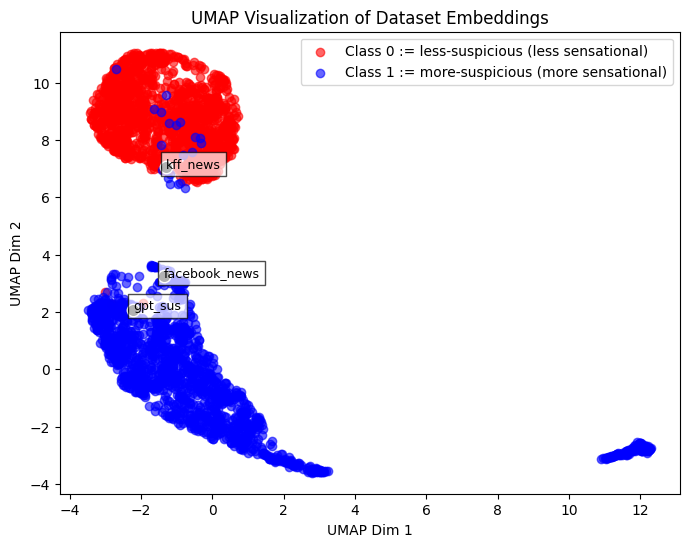

In [160]:
# double-check model configs; a good sanity check, lol.
print(model.config)



# make the plot!!
plt.figure(figsize=(8,6))

# Class 0; should be the 'more-suspicious' class, i.e., more sensational 
plt.scatter(
    reduced[labels==0, 0], # our mask is train_labels==0, so here we select x-coords with our mask for class 0 
    reduced[labels==0, 1], # ... select y-coords with our mask for class 1
    c='red',
    label='Class 0 := less-suspicious (less sensational)',
    alpha=0.6
)

# Class 1
plt.scatter(
    reduced[labels==1, 0], # do the same for class 1
    reduced[labels==1, 1],
    c='blue',
    label='Class 1 := more-suspicious (more sensational)',
    alpha=0.6
)


if include_demo:
    custom_tags = ["gpt_sus","facebook_news","kff_news"]
    # Annotate last 3 custom samples
    for i, tag in enumerate(custom_tags):
        idx = -len(custom_tags) + i  # e.g. -3, -2, -1
        print(tag)
        x, y = reduced[idx, 0], reduced[idx, 1]
        plt.scatter(x, y, c='black', s=80, edgecolors='white', zorder=3)
        plt.text(
            x, y, tag, fontsize=9,
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.7)
        )



plt.title("UMAP Visualization of Dataset Embeddings")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.legend()
plt.show()

# Other Notes

In [ ]:
# note from Preet, to be used for the simple feedforward nn models 
# import joblib

# # save the memory of the model to a .pkl 
# joblib.dump(value={name_of_model}, filename='{filename}.pkl')

# # load the model into memory, prevents re-training
# loaded_model = joblib.load(filename='{filename}.pkl')

## Attempt to add Multi-class Classification

We can use the existing GPT-2 Backbone, just need to retrain the classification head, reusing the pretrained weights for the rest of the model

#### Update Model and Tokenizer Setup

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "gpt2"
num_labels = 3 # 3 labels, 0: less sus, 1: more sus, 2: neutral

# load GPT-2 backbone with fresh classification head for 3-class classification
model_path = "training-args-openai-community/after-train-11-8-2025-v2"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

#### Update Label Mapping

In [6]:
label2id = {
    "less_suspicious":0,
    "neutral":1,
    "more_suspicious":2
}
id2label = {v: k for k, v in label2id.items()}


#### Get Confidence Scores from 2-Class Model

In [ ]:
import torch.nn.functional as F
# load the 2-class model, tokenizer
model.eval()

which_df = 'pulk17'

df = get_df(which_df)
confidences = []
for text in tqdm(df['text']): 
    inputs = tokenizer(text,
                       return_tensors='pt',
                       truncation=True,
                       max_length=128
                       )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
        # shape: [prob_less, prob_more]
        probs = F.softmax(logits, dim=-1).cpu().numpy()[0] # use the cpu
        confidence = float(probs[1]) # probability that it is more suspicious 
        confidences.append(confidence)

df['confidence'] = confidences

   Unnamed: 0                                              title  \
0        2619  Ex-CIA head says Trump remarks on Russia inter...   
1       16043  YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...   
2         876  Federal Reserve governor Powell's policy views...   
3       19963  SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...   
4       10783  NANCY PELOSI ARROGANTLY DISMISSES Questions on...   

                                                text          subject  \
0  Former CIA director John Brennan on Friday cri...     politicsNews   
1  How did this man come to OWN this store? There...  Government News   
2  President Donald Trump on Thursday tapped Fede...     politicsNews   
3  Hillary Clinton ally David Brock is offering t...        left-news   
4  Pleading ignorance is a perfect ploy for Nancy...         politics   

                date  label  
0     July 22, 2017       1  
1       Jun 19, 2017      0  
2  November 2, 2017       1  
3       Sep 17, 2016      0  
4 

  8%|▊         | 2541/30000 [05:42<1:01:38,  7.42it/s]


KeyboardInterrupt: 

#### Prepare Dataset with 3 Classes

In [9]:
def relabel_for_multiclass(row, threshold_low=0.45, threshold_high=0.55):
    if row['confidence'] < threshold_low:
        return 0 # less suspicious if < 0.45
    elif row['confidence'] < threshold_high:
        return 2 # more suspicious if > 0.45
    else:
        return 1 # neutral if > 0.45 & < 0.55

# assumes that we have a df with 'confidence' column,
# if not, 
df['label'] = df.apply(relabel_for_multiclass, axis=1)

    

NameError: name 'df' is not defined